## Load Raw Data

In [1]:
import zipfile
import pandas as pd

with zipfile.ZipFile("/content/drive/MyDrive/Student/Mohit/Dataset/Skin_Cancer_Malignant_vs_Benign/archive.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")



## Required External Libs

In [2]:
!pip install flwr[simulation]
!pip install torch
!pip install torchvision

INFO: pip is looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Started Federated Learning Models Code

In [3]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()


Training on cuda
Flower 1.23.0 / PyTorch 2.8.0+cu126


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Data Pre Processing

Federated Data Partitioning with Stratification

✅ Loaded CSVs:
Train: 2637 | Val: 330 | Test: 330
Clients: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Client 0 -> Train samples: 264, Val samples: 33


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


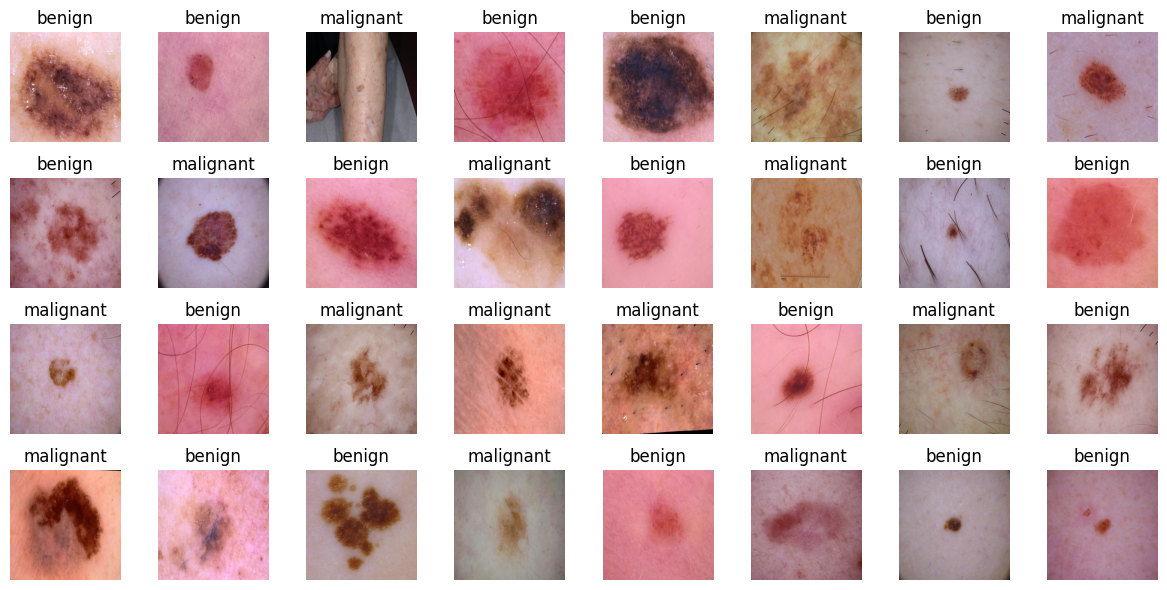


📊 Label distribution per client (Train):
Client 0: {'benign': 144, 'malignant': 120} (Total=264)
Client 1: {'benign': 144, 'malignant': 120} (Total=264)
Client 2: {'benign': 144, 'malignant': 120} (Total=264)
Client 3: {'benign': 144, 'malignant': 120} (Total=264)
Client 4: {'benign': 144, 'malignant': 120} (Total=264)
Client 5: {'benign': 144, 'malignant': 120} (Total=264)
Client 6: {'benign': 144, 'malignant': 120} (Total=264)
Client 7: {'benign': 144, 'malignant': 119} (Total=263)
Client 8: {'benign': 144, 'malignant': 119} (Total=263)
Client 9: {'benign': 144, 'malignant': 119} (Total=263)

📊 Label distribution per client (Validation):
Client 0: {'benign': 19, 'malignant': 14} (Total=33)
Client 1: {'benign': 19, 'malignant': 14} (Total=33)
Client 2: {'benign': 19, 'malignant': 14} (Total=33)
Client 3: {'benign': 19, 'malignant': 14} (Total=33)
Client 4: {'benign': 20, 'malignant': 13} (Total=33)
Client 5: {'benign': 20, 'malignant': 13} (Total=33)
Client 6: {'benign': 20, 'maligna

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [4]:
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

# -----------------------------
# CONFIGS
# -----------------------------
N_CLASS = 2
N_ROUND = 5
NUM_CLIENTS = 10
BATCH_SIZE = 32
EPOCH = 10

CSV_BASE_PATH = "/content/drive/MyDrive/Student/Mohit/Dataset/Federated_Learning_Project_2/Processed_CSV/"

# -----------------------------
# TRANSFORMS
# -----------------------------
pytorch_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# -----------------------------
# CUSTOM DATASET CLASS
# -----------------------------
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.label_to_idx = {'benign': 0, 'malignant': 1}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['file_path']
        label = self.label_to_idx[row['label']]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label
    @property
    def classes(self):
        return list(self.label_to_idx.keys())


# -----------------------------
# LOAD CSV FILES
# -----------------------------
train_df = pd.read_csv(CSV_BASE_PATH + "train_df_with_client.csv")
val_df = pd.read_csv(CSV_BASE_PATH + "val_df_with_client.csv")
test_df = pd.read_csv(CSV_BASE_PATH + "test_df_with_client.csv")

print("✅ Loaded CSVs:")
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print("Clients:", sorted(train_df['client_id'].unique()))

# -----------------------------
# FUNCTION: LOAD DATA FOR ONE CLIENT
# -----------------------------
def load_datasets(client_id):
    """Return train and validation DataLoaders for a specific client."""
    client_train = train_df[train_df['client_id'] == client_id]
    client_val = val_df[val_df['client_id'] == client_id]

    train_dataset = CustomImageDataset(client_train, transform=pytorch_transforms)
    val_dataset = CustomImageDataset(client_val, transform=pytorch_transforms)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader

# -----------------------------
# EXAMPLE: LOAD DATA FOR CLIENT 0
# -----------------------------
trainloader, valloader = load_datasets(0)

print(f"Client 0 -> Train samples: {len(trainloader.dataset)}, Val samples: {len(valloader.dataset)}")

# -----------------------------
# VISUALIZE A BATCH (OPTIONAL)
# -----------------------------
batch = next(iter(valloader))
images, labels = batch

# Convert labels to class names for display
idx_to_label = {0: "benign", 1: "malignant"}

# Denormalize for visualization
images = images.permute(0, 2, 3, 1).numpy()
images = (images * 0.5 + 0.5).clip(0, 1)

fig, axs = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    if i < len(images):
        ax.imshow(images[i])
        ax.set_title(idx_to_label[labels[i].item()])
        ax.axis("off")
plt.tight_layout()
plt.show()

# -----------------------------
# CHECK DISTRIBUTION PER CLIENT
# -----------------------------
print("\n📊 Label distribution per client (Train):")
for cid in sorted(train_df['client_id'].unique()):
    subset = train_df[train_df['client_id'] == cid]
    dist = subset['label'].value_counts().to_dict()
    print(f"Client {cid}: {dist} (Total={len(subset)})")

print("\n📊 Label distribution per client (Validation):")
for cid in sorted(val_df['client_id'].unique()):
    subset = val_df[val_df['client_id'] == cid]
    dist = subset['label'].value_counts().to_dict()
    print(f"Client {cid}: {dist} (Total={len(subset)})")

# -----------------------------
# VAL SET (GLOBAL EVALUATION)
# -----------------------------
val_dataset = CustomImageDataset(test_df, transform=pytorch_transforms)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# TEST SET (GLOBAL EVALUATION)
# -----------------------------
test_dataset = CustomImageDataset(test_df, transform=pytorch_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"\n🧪 Global Test Set -> Total samples: {len(test_dataset)}")


### Model Creating

In [5]:
import torch.nn as nn
from torchvision import models
from torchvision.models import (
    ResNet50_Weights, DenseNet201_Weights, VGG19_Weights,
    EfficientNet_B0_Weights, MobileNet_V2_Weights, Inception_V3_Weights
)

# ------------------------- Helper -------------------------
def determineFinalLayer(model):
    """Find the number of input features for the last linear layer."""
    if hasattr(model, "fc"):  # ResNet, Inception
        return model.fc.in_features
    elif hasattr(model, "classifier"):
        if isinstance(model.classifier, nn.Linear):  # DenseNet, MobileNet
            return model.classifier.in_features
        elif isinstance(model.classifier, nn.Sequential):  # VGG, EfficientNet
            # Find last linear layer in Sequential
            for layer in reversed(model.classifier):
                if isinstance(layer, nn.Linear):
                    return layer.in_features
    raise NotImplementedError("Unknown model architecture — can't determine final layer")


# ------------------------- Main Model Factory -------------------------
def createTensorModel(num_classes=2):
    """Create and customize a CNN model for classification."""

    MODEL_NAME = "mobilenet_v2"

    if MODEL_NAME == "resnet50":
        weights = ResNet50_Weights.DEFAULT
        model = models.resnet50(weights=weights)
        model.fc = nn.Linear(determineFinalLayer(model), num_classes)

    elif MODEL_NAME == "densenet201":
        weights = DenseNet201_Weights.DEFAULT
        model = models.densenet201(weights=weights)
        model.classifier = nn.Linear(determineFinalLayer(model), num_classes)

    elif MODEL_NAME == "vgg19":
        weights = VGG19_Weights.DEFAULT
        model = models.vgg19(weights=weights)
        model.classifier[-1] = nn.Linear(determineFinalLayer(model), num_classes)

    elif MODEL_NAME == "mobilenet_v2":
        weights = MobileNet_V2_Weights.DEFAULT
        model = models.mobilenet_v2(weights=weights)
        model.classifier[-1] = nn.Linear(determineFinalLayer(model), num_classes)

    elif MODEL_NAME == "inception_v3":
        weights = Inception_V3_Weights.DEFAULT
        model = models.inception_v3(weights=weights, aux_logits=False)
        model.fc = nn.Linear(determineFinalLayer(model), num_classes)

    elif MODEL_NAME == "efficientnet_b0":
        weights = EfficientNet_B0_Weights.DEFAULT
        model = models.efficientnet_b0(weights=weights)
        model.classifier[1] = nn.Linear(determineFinalLayer(model), num_classes)

    else:
        raise ValueError(f"Model {MODEL_NAME} not supported")

    return model


In [6]:
def train(net, trainloader, epochs=1, verbose=False):
    net.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    running_loss = 0.0
    running_correct = 0
    total_samples = 0

    for epoch in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()       #loss

            running_loss += loss.item() * labels.size(0)    #adding losses for per image
            running_correct += (outputs.argmax(dim=1) == labels).sum().item()
            total_samples += labels.size(0)

    # Avoid division by zero
    if total_samples == 0:
        return 0.0, 0.0

    avg_loss = running_loss / total_samples
    avg_acc = running_correct / total_samples
    if verbose:
        print(f"[train] loss={avg_loss:.4f}, acc={avg_acc:.4f}")
    return avg_loss, avg_acc


In [7]:
# Testing function
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:     # <-- fixed here
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader)
    accuracy = correct / total
    return loss, accuracy


In [8]:
#for server
from collections import OrderedDict
import numpy as np

def set_parameters(net, parameters: list[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})  #{layer name: tensor[parameters]}
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> list[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


In [9]:
from flwr.client import NumPyClient
from pathlib import Path
# all_round_metrics = []

class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader, client_id):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.client_id = client_id


    def get_parameters(self, config):
        return get_parameters(self.net)         #return the current local parameters

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        # train() now returns avg train loss and accuracy
        train_loss, train_acc = train(self.net, self.trainloader, epochs=EPOCH)

        # Return metrics dict with train keys
        return get_parameters(self.net), len(self.trainloader.dataset), {
            "train_loss": float(train_loss),
            "train_accuracy": float(train_acc),
        }

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        val_loss, val_acc = test(self.net, self.valloader)
        # Must return loss in metrics so server can aggregate it
        return float(val_loss), len(self.valloader.dataset), {
            "accuracy": float(val_acc),
            "loss": float(val_loss),
        }


In [10]:
from flwr.common import Context
from flwr.client import Client

def client_fn(context: Context) -> Client:
    partition_id = context.node_config["partition-id"]
    trainloader, valloader = load_datasets(partition_id)
    net = createTensorModel(num_classes=N_CLASS).to(DEVICE)
    return FlowerClient(net, trainloader, valloader, client_id=partition_id).to_client()


In [11]:
from flwr.client import ClientApp

# Wrap the client function into a ClientApp
client = ClientApp(client_fn=client_fn)


In [12]:
from flwr.simulation import run_simulation

# Configure resources per client
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}


In [13]:
from typing import List, Tuple, Dict
train_metrics_per_round = []
all_round_metrics = []  # validation metrics as before

def aggregate_train_metrics(metrics: List[Tuple[int, Dict[str, float]]]) -> Dict[str, float]:
    # Debug print to see what clients returned
    # (comment out in final runs if noisy)
    print("DEBUG aggregate_train_metrics received:", metrics)

    total_examples = sum(n for n, _ in metrics)
    if total_examples == 0:
        avg_train_loss = 0.0
        avg_train_acc = 0.0
    else:
        avg_train_loss = sum(n * m.get("train_loss", 0.0) for n, m in metrics) / total_examples
        avg_train_acc = sum(n * m.get("train_accuracy", 0.0) for n, m in metrics) / total_examples

    train_metrics_per_round.append((len(train_metrics_per_round) + 1, avg_train_loss, avg_train_acc))

    # Return a dictionary expected by Flower (can be empty or include agg values)
    return {"train_loss": avg_train_loss, "train_accuracy": avg_train_acc}

In [14]:
def weighted_average(metrics: List[Tuple[int, Dict[str, float]]]) -> Dict[str, float]:
    # metrics: List[(num_examples, {"accuracy":..., "loss":...}), ...]
    total_examples = sum(n for n, _ in metrics)
    if total_examples == 0:
        avg_acc = 0.0
        avg_loss = 0.0
    else:
        avg_acc = sum(n * m.get("accuracy", 0.0) for n, m in metrics) / total_examples
        avg_loss = sum(n * m.get("loss", 0.0) for n, m in metrics) / total_examples

    all_round_metrics.append((len(all_round_metrics) + 1, avg_loss, avg_acc))
    return {"accuracy": avg_acc}


In [15]:
import os

os.makedirs("/content/global_models", exist_ok=True)
print("Created /content/global_models directory if it did not exist.")

Created /content/global_models directory if it did not exist.


In [16]:
from flwr.server import ServerApp, ServerAppComponents, ServerConfig
from flwr.server.strategy import FedAvg
from flwr.common import parameters_to_ndarrays
import torch

def server_fn(context: Context) -> ServerAppComponents:
    """ServerApp with FedAvg that saves the global model each round."""

    class SaveFedAvg(FedAvg):
        """FedAvg that saves aggregated global model after each round."""

        def aggregate_fit(self, server_round, results, failures):
            aggregated_result = super().aggregate_fit(server_round, results, failures)

            # Make sure aggregation succeeded
            if aggregated_result is not None:
                aggregated_parameters, _ = aggregated_result

                # Convert to NumPy arrays
                ndarrays = parameters_to_ndarrays(aggregated_parameters)

                # Create and load into model
                model = createTensorModel(num_classes=N_CLASS)  # your model class
                set_parameters(model, ndarrays)  # your helper to map ndarrays → model.state_dict()

                save_path = f"/content/global_models/global_model_round_{server_round}.pth"
                torch.save(model.state_dict(), save_path)
                # torch.save(model, f"/content/global_models/global_model_full_round_{server_round}.pth")
                print(f"💾 [SERVER] Saved global model after round {server_round} → {save_path}")

            return aggregated_result

    strategy = SaveFedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=NUM_CLIENTS,
        min_evaluate_clients=4,
        min_available_clients=NUM_CLIENTS,
        evaluate_metrics_aggregation_fn=weighted_average,
        fit_metrics_aggregation_fn=aggregate_train_metrics,
    )

    config = ServerConfig(num_rounds=N_ROUND)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)


In [17]:
# Run the federated learning simulation and capture history + final params
history = run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=2107) 2025-11-12 16:09:28.330984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=2107) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=2107) E0000 00:00:1762963768.366006    2107 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for pl

(ClientAppActor pid=2107) Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]
100%|██████████| 13.6M/13.6M [00:00<00:00, 146MB/s]
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


DEBUG aggregate_train_metrics received: [(264, {'train_loss': 0.1425476985334447, 'train_accuracy': 0.9386363636363636}), (264, {'train_loss': 0.11772803037681363, 'train_accuracy': 0.9522727272727273}), (264, {'train_loss': 0.11409564098964135, 'train_accuracy': 0.9628787878787879}), (264, {'train_loss': 0.11065675671861479, 'train_accuracy': 0.9553030303030303}), (263, {'train_loss': 0.1400513743023838, 'train_accuracy': 0.9399239543726235}), (264, {'train_loss': 0.11949563125980961, 'train_accuracy': 0.95}), (263, {'train_loss': 0.15091991310677147, 'train_accuracy': 0.9452471482889734}), (264, {'train_loss': 0.12817334863216137, 'train_accuracy': 0.9522727272727273}), (264, {'train_loss': 0.13408081539850117, 'train_accuracy': 0.9446969696969697}), (263, {'train_loss': 0.1240624123778789, 'train_accuracy': 0.9460076045627377})]
💾 [SERVER] Saved global model after round 1 → /content/global_models/global_model_round_1.pth


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


DEBUG aggregate_train_metrics received: [(264, {'train_loss': 0.11162781529128551, 'train_accuracy': 0.9602272727272727}), (263, {'train_loss': 0.07170867211798014, 'train_accuracy': 0.9722433460076045}), (264, {'train_loss': 0.06128588999007744, 'train_accuracy': 0.9768939393939394}), (263, {'train_loss': 0.09345247180638445, 'train_accuracy': 0.9661596958174905}), (264, {'train_loss': 0.11123893188425538, 'train_accuracy': 0.9621212121212122}), (264, {'train_loss': 0.08459231368139047, 'train_accuracy': 0.968939393939394}), (264, {'train_loss': 0.0928872224451466, 'train_accuracy': 0.9674242424242424}), (264, {'train_loss': 0.11321547959338535, 'train_accuracy': 0.9609848484848484}), (263, {'train_loss': 0.11607307812461042, 'train_accuracy': 0.9612167300380228}), (264, {'train_loss': 0.08018833118293321, 'train_accuracy': 0.9734848484848485})]
💾 [SERVER] Saved global model after round 2 → /content/global_models/global_model_round_2.pth


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


DEBUG aggregate_train_metrics received: [(264, {'train_loss': 0.06888981576388081, 'train_accuracy': 0.9761363636363637}), (264, {'train_loss': 0.05054151426937262, 'train_accuracy': 0.9848484848484849}), (264, {'train_loss': 0.09187848676052508, 'train_accuracy': 0.9678030303030303}), (264, {'train_loss': 0.0811010242849024, 'train_accuracy': 0.9715909090909091}), (263, {'train_loss': 0.06285516951018909, 'train_accuracy': 0.9745247148288974}), (264, {'train_loss': 0.08467516376509923, 'train_accuracy': 0.9708333333333333}), (264, {'train_loss': 0.06970027646924735, 'train_accuracy': 0.975}), (263, {'train_loss': 0.08532377095227289, 'train_accuracy': 0.9703422053231939}), (263, {'train_loss': 0.08725513846369128, 'train_accuracy': 0.9680608365019011}), (264, {'train_loss': 0.05649559933191278, 'train_accuracy': 0.978030303030303})]
💾 [SERVER] Saved global model after round 3 → /content/global_models/global_model_round_3.pth


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


DEBUG aggregate_train_metrics received: [(263, {'train_loss': 0.0632748667755166, 'train_accuracy': 0.9806083650190114}), (264, {'train_loss': 0.06275721000733249, 'train_accuracy': 0.9784090909090909}), (264, {'train_loss': 0.05044014951966925, 'train_accuracy': 0.9810606060606061}), (264, {'train_loss': 0.0648686005991432, 'train_accuracy': 0.9787878787878788}), (264, {'train_loss': 0.09157584245937565, 'train_accuracy': 0.9712121212121212}), (264, {'train_loss': 0.06372071027290076, 'train_accuracy': 0.9799242424242425}), (263, {'train_loss': 0.07330956583233557, 'train_accuracy': 0.9783269961977187}), (263, {'train_loss': 0.07593193040583496, 'train_accuracy': 0.9779467680608365}), (264, {'train_loss': 0.045562969098947095, 'train_accuracy': 0.981439393939394}), (264, {'train_loss': 0.05050085467554516, 'train_accuracy': 0.9821969696969697})]
💾 [SERVER] Saved global model after round 4 → /content/global_models/global_model_round_4.pth


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


DEBUG aggregate_train_metrics received: [(264, {'train_loss': 0.04738026277063358, 'train_accuracy': 0.984469696969697}), (264, {'train_loss': 0.050620445618970375, 'train_accuracy': 0.9833333333333333}), (264, {'train_loss': 0.05991555622295533, 'train_accuracy': 0.9787878787878788}), (264, {'train_loss': 0.06228487291726086, 'train_accuracy': 0.9787878787878788}), (264, {'train_loss': 0.058361411619592796, 'train_accuracy': 0.9837121212121213}), (263, {'train_loss': 0.07286888457828468, 'train_accuracy': 0.9783269961977187}), (264, {'train_loss': 0.06664343670709058, 'train_accuracy': 0.9784090909090909}), (263, {'train_loss': 0.056175554096486294, 'train_accuracy': 0.9825095057034221}), (264, {'train_loss': 0.06767022040047309, 'train_accuracy': 0.9772727272727273}), (263, {'train_loss': 0.04359361160729796, 'train_accuracy': 0.9844106463878327})]
💾 [SERVER] Saved global model after round 5 → /content/global_models/global_model_round_5.pth


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 794.64s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5060730304569006
INFO :      		round 2: 0.32836764510720967
INFO :      		round 3: 0.21803058416989957
INFO :      		round 4: 0.301944908499717
INFO :      		round 5: 0.2502372710980126
INFO :      	History (metrics, distributed, fit):
INFO :      	{'train_accuracy': [(1, 0.9487296169890027),
INFO :      	                    (2, 0.9669700417140691),
INFO :      	                    (3, 0.9737201365187713),
INFO :      	                    (4, 0.9789912779673872),
INFO :      	                    (5, 0.9810011376564278)],
INFO :      	 'train_loss': [(1, 0.12816959970722885),
INFO :      	                (2, 0.09362688668674916),
INFO :      	                (3, 0.07386635542201082),
INFO :      	                (4, 0.06418671078638183),
INFO :      	                (5, 0.058

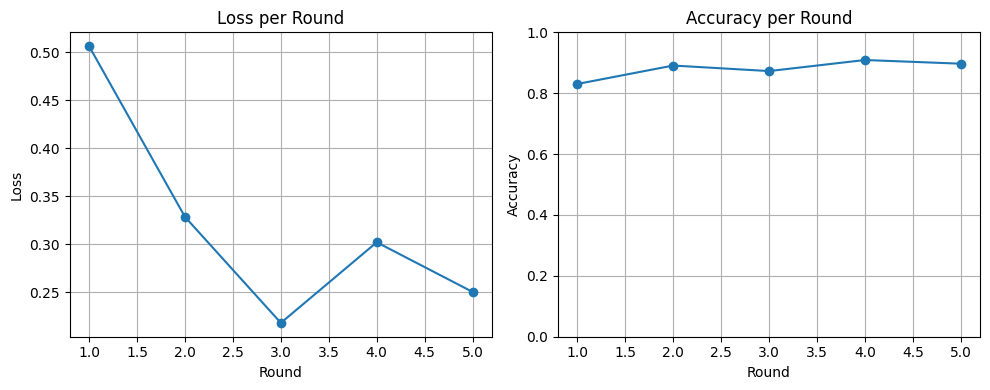

In [18]:
rounds = [r for r, _, _ in all_round_metrics]
losses = [l for _, l, _ in all_round_metrics]
accuracies = [a for _, _, a in all_round_metrics]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(rounds, losses, marker="o")
plt.title("Loss per Round")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(rounds, accuracies, marker="o")
plt.title("Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.ylim(0,1.0)
plt.grid(True)
plt.tight_layout()
plt.show()


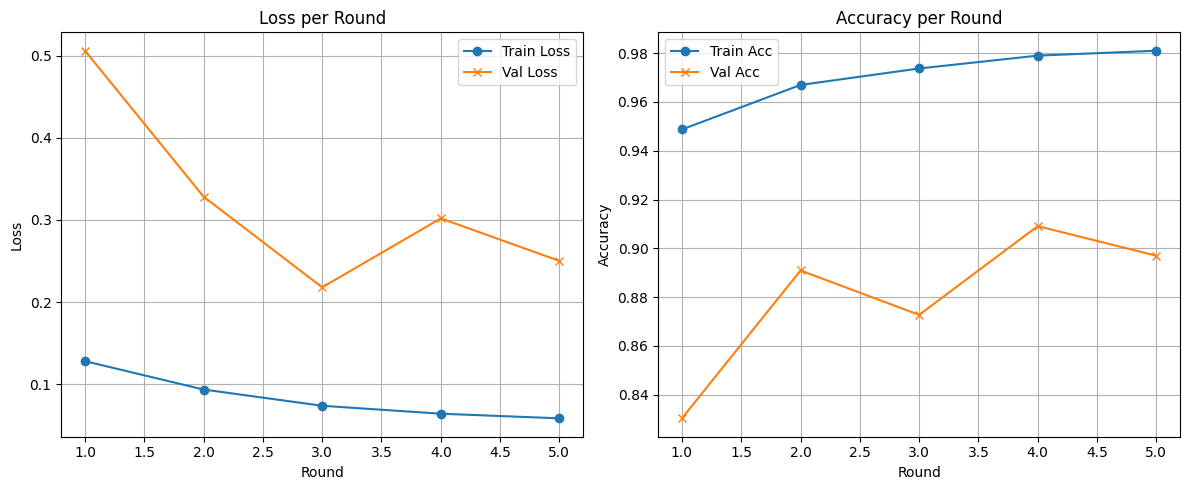

In [19]:
# After simulation finishes
rounds = [r for r, _, _ in train_metrics_per_round]
train_losses = [l for _, l, _ in train_metrics_per_round]
train_accs = [a for _, _, a in train_metrics_per_round]

val_rounds = [r for r, _, _ in all_round_metrics]
val_losses = [l for _, l, _ in all_round_metrics]
val_accs = [a for _, _, a in all_round_metrics]

# You probably want to align rounds: both should have same length (num_rounds)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(rounds, train_losses, marker='o', label="Train Loss")
plt.plot(val_rounds, val_losses, marker='x', label="Val Loss")
plt.xlabel("Round"); plt.ylabel("Loss"); plt.title("Loss per Round"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(rounds, train_accs, marker='o', label="Train Acc")
plt.plot(val_rounds, val_accs, marker='x', label="Val Acc")
plt.xlabel("Round"); plt.ylabel("Accuracy"); plt.title("Accuracy per Round"); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


## Global Model Performance : Val Set

In [20]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# -------------------- EVALUATION FUNCTION --------------------
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    acc = np.mean(np.array(y_true) == np.array(y_pred))
    return acc, y_true, y_pred

In [21]:
round_models = []
for r in range(1, N_ROUND+1):
    print(f"Round: {r} loaded")
    model = createTensorModel(num_classes=N_CLASS)  # same architecture used in training
    model.load_state_dict(torch.load(f"/content/global_models/global_model_round_{r}.pth", map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    round_models.append((r, model))
print(f"✅ Loaded {len(round_models)} global models")


Round: 1 loaded
Round: 2 loaded
Round: 3 loaded
Round: 4 loaded
Round: 5 loaded
✅ Loaded 5 global models


In [22]:
for round_num, model in round_models:
    print(f"\n================= Evaluating Global Model: Round {round_num} =================")

    client_accuracies = []
    all_y_true = []
    all_y_pred = []

    for client_id in range(NUM_CLIENTS):
        _, valloader = load_datasets(client_id)  # or load_testset(client_id) if you have one
        acc, y_true, y_pred = evaluate_model(model, valloader)
        client_accuracies.append(acc)
        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)

        print(f"Client {client_id} Accuracy: {acc:.4f}")

    avg_acc = np.mean(client_accuracies)
    print(f"\nAverage Accuracy Across Clients (Round {round_num}): {avg_acc:.4f}")

    # Global metrics
    report = classification_report(all_y_true, all_y_pred, digits=4)
    cm = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nGlobal Classification Report for Round {round_num}:\n{report}")
    print(f"Confusion Matrix for Round {round_num}:\n{cm}")



================= Evaluating Global Model: Round 1 =================
Client 0 Accuracy: 0.7576
Client 1 Accuracy: 0.7879
Client 2 Accuracy: 0.9091
Client 3 Accuracy: 0.7273
Client 4 Accuracy: 0.8788
Client 5 Accuracy: 0.8182
Client 6 Accuracy: 0.8182
Client 7 Accuracy: 0.8485
Client 8 Accuracy: 0.8788
Client 9 Accuracy: 0.9394

Average Accuracy Across Clients (Round 1): 0.8364

Global Classification Report for Round 1:
              precision    recall  f1-score   support

           0     0.9329    0.7806    0.8500       196
           1     0.7410    0.9179    0.8200       134

    accuracy                         0.8364       330
   macro avg     0.8369    0.8493    0.8350       330
weighted avg     0.8550    0.8364    0.8378       330

Confusion Matrix for Round 1:
[[153  43]
 [ 11 123]]

================= Evaluating Global Model: Round 2 =================


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Client 0 Accuracy: 0.7879
Client 1 Accuracy: 0.7879
Client 2 Accuracy: 0.9394
Client 3 Accuracy: 0.9394
Client 4 Accuracy: 0.9091
Client 5 Accuracy: 0.9091
Client 6 Accuracy: 0.8788
Client 7 Accuracy: 0.9394
Client 8 Accuracy: 0.8485
Client 9 Accuracy: 0.8788

Average Accuracy Across Clients (Round 2): 0.8818

Global Classification Report for Round 2:
              precision    recall  f1-score   support

           0     0.8945    0.9082    0.9013       196
           1     0.8626    0.8433    0.8528       134

    accuracy                         0.8818       330
   macro avg     0.8785    0.8757    0.8770       330
weighted avg     0.8815    0.8818    0.8816       330

Confusion Matrix for Round 2:
[[178  18]
 [ 21 113]]

================= Evaluating Global Model: Round 3 =================


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Client 0 Accuracy: 0.7879
Client 1 Accuracy: 0.8485
Client 2 Accuracy: 0.9394
Client 3 Accuracy: 0.9091
Client 4 Accuracy: 0.9091
Client 5 Accuracy: 0.8788
Client 6 Accuracy: 0.9091
Client 7 Accuracy: 0.9697
Client 8 Accuracy: 0.8485
Client 9 Accuracy: 0.8788

Average Accuracy Across Clients (Round 3): 0.8879

Global Classification Report for Round 3:
              precision    recall  f1-score   support

           0     0.8995    0.9133    0.9063       196
           1     0.8702    0.8507    0.8604       134

    accuracy                         0.8879       330
   macro avg     0.8849    0.8820    0.8834       330
weighted avg     0.8876    0.8879    0.8877       330

Confusion Matrix for Round 3:
[[179  17]
 [ 20 114]]

================= Evaluating Global Model: Round 4 =================


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Client 0 Accuracy: 0.8182
Client 1 Accuracy: 0.8485
Client 2 Accuracy: 0.9394
Client 3 Accuracy: 0.9091
Client 4 Accuracy: 0.9091
Client 5 Accuracy: 0.8485
Client 6 Accuracy: 0.9394
Client 7 Accuracy: 0.9394
Client 8 Accuracy: 0.8182
Client 9 Accuracy: 0.9091

Average Accuracy Across Clients (Round 4): 0.8879

Global Classification Report for Round 4:
              precision    recall  f1-score   support

           0     0.8955    0.9184    0.9068       196
           1     0.8760    0.8433    0.8593       134

    accuracy                         0.8879       330
   macro avg     0.8857    0.8808    0.8831       330
weighted avg     0.8876    0.8879    0.8875       330

Confusion Matrix for Round 4:
[[180  16]
 [ 21 113]]

================= Evaluating Global Model: Round 5 =================


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Client 0 Accuracy: 0.8182
Client 1 Accuracy: 0.8182
Client 2 Accuracy: 0.9394
Client 3 Accuracy: 0.9091
Client 4 Accuracy: 0.9091
Client 5 Accuracy: 0.8485
Client 6 Accuracy: 0.9091
Client 7 Accuracy: 0.9394
Client 8 Accuracy: 0.8788
Client 9 Accuracy: 0.9394

Average Accuracy Across Clients (Round 5): 0.8909

Global Classification Report for Round 5:
              precision    recall  f1-score   support

           0     0.8922    0.9286    0.9100       196
           1     0.8889    0.8358    0.8615       134

    accuracy                         0.8909       330
   macro avg     0.8905    0.8822    0.8858       330
weighted avg     0.8908    0.8909    0.8903       330

Confusion Matrix for Round 5:
[[182  14]
 [ 22 112]]


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


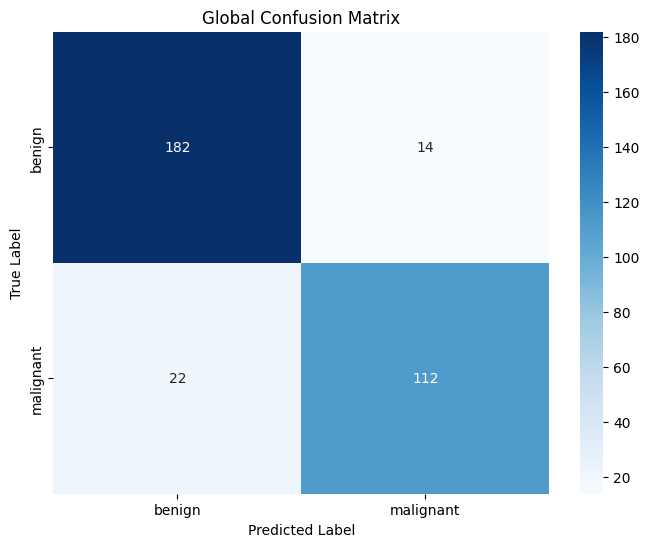

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Global Confusion Matrix')
plt.show()

## Global Model Performance : Test Set

In [24]:
from torch.utils.data import DataLoader


def load_test_datasets(client_id):
    client_test = test_df[test_df['client_id'] == client_id]
    test_dataset = CustomImageDataset(client_test, transform=pytorch_transforms)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    return test_loader


In [25]:
for round_num, model in round_models:
    print(f"\n================= Evaluating Global Model: Round {round_num} =================")

    client_accuracies = []
    all_y_true = []
    all_y_pred = []

    for client_id in range(NUM_CLIENTS):
        testloader = load_test_datasets(client_id)
        acc, y_true, y_pred = evaluate_model(model, testloader)
        client_accuracies.append(acc)
        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)

        print(f"Client {client_id} Accuracy: {acc:.4f}")

    avg_acc = np.mean(client_accuracies)
    print(f"\nAverage Accuracy Across Clients (Round {round_num}): {avg_acc:.4f}")

    # Global metrics
    report = classification_report(all_y_true, all_y_pred, digits=4)
    test_cm = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nGlobal Classification Report for Round {round_num}:\n{report}")
    print(f"Confusion Matrix for Round {round_num}:\n{cm}")



================= Evaluating Global Model: Round 1 =================
Client 0 Accuracy: 0.8485
Client 1 Accuracy: 0.7879
Client 2 Accuracy: 1.0000
Client 3 Accuracy: 0.7879
Client 4 Accuracy: 0.8485
Client 5 Accuracy: 0.8485
Client 6 Accuracy: 0.8788
Client 7 Accuracy: 0.8485
Client 8 Accuracy: 0.8788
Client 9 Accuracy: 0.9394

Average Accuracy Across Clients (Round 1): 0.8667

Global Classification Report for Round 1:
              precision    recall  f1-score   support

           0     0.9110    0.8110    0.8581       164
           1     0.8315    0.9217    0.8743       166

    accuracy                         0.8667       330
   macro avg     0.8712    0.8663    0.8662       330
weighted avg     0.8710    0.8667    0.8662       330

Confusion Matrix for Round 1:
[[182  14]
 [ 22 112]]

================= Evaluating Global Model: Round 2 =================
Client 0 Accuracy: 0.9394


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Client 1 Accuracy: 0.8485
Client 2 Accuracy: 0.9697
Client 3 Accuracy: 0.8788
Client 4 Accuracy: 0.8182
Client 5 Accuracy: 0.7576
Client 6 Accuracy: 0.8788
Client 7 Accuracy: 0.8485
Client 8 Accuracy: 0.8788
Client 9 Accuracy: 0.9697

Average Accuracy Across Clients (Round 2): 0.8788

Global Classification Report for Round 2:
              precision    recall  f1-score   support

           0     0.8523    0.9146    0.8824       164
           1     0.9091    0.8434    0.8750       166

    accuracy                         0.8788       330
   macro avg     0.8807    0.8790    0.8787       330
weighted avg     0.8809    0.8788    0.8787       330

Confusion Matrix for Round 2:
[[182  14]
 [ 22 112]]

================= Evaluating Global Model: Round 3 =================
Client 0 Accuracy: 0.9697


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Client 1 Accuracy: 0.8788
Client 2 Accuracy: 0.9091
Client 3 Accuracy: 0.8485
Client 4 Accuracy: 0.7576
Client 5 Accuracy: 0.9091
Client 6 Accuracy: 0.9091
Client 7 Accuracy: 0.9394
Client 8 Accuracy: 0.8788
Client 9 Accuracy: 0.9394

Average Accuracy Across Clients (Round 3): 0.8939

Global Classification Report for Round 3:
              precision    recall  f1-score   support

           0     0.8603    0.9390    0.8980       164
           1     0.9338    0.8494    0.8896       166

    accuracy                         0.8939       330
   macro avg     0.8971    0.8942    0.8938       330
weighted avg     0.8973    0.8939    0.8937       330

Confusion Matrix for Round 3:
[[182  14]
 [ 22 112]]

================= Evaluating Global Model: Round 4 =================
Client 0 Accuracy: 0.9697


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Client 1 Accuracy: 0.8485
Client 2 Accuracy: 0.9091
Client 3 Accuracy: 0.8788
Client 4 Accuracy: 0.7879
Client 5 Accuracy: 0.8788
Client 6 Accuracy: 0.9091
Client 7 Accuracy: 0.9091
Client 8 Accuracy: 0.8788
Client 9 Accuracy: 0.9394

Average Accuracy Across Clients (Round 4): 0.8909

Global Classification Report for Round 4:
              precision    recall  f1-score   support

           0     0.8596    0.9329    0.8947       164
           1     0.9276    0.8494    0.8868       166

    accuracy                         0.8909       330
   macro avg     0.8936    0.8912    0.8908       330
weighted avg     0.8938    0.8909    0.8907       330

Confusion Matrix for Round 4:
[[182  14]
 [ 22 112]]

================= Evaluating Global Model: Round 5 =================
Client 0 Accuracy: 0.9394


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Client 1 Accuracy: 0.8485
Client 2 Accuracy: 0.9091
Client 3 Accuracy: 0.8485
Client 4 Accuracy: 0.7879
Client 5 Accuracy: 0.8182
Client 6 Accuracy: 0.9394
Client 7 Accuracy: 0.9091
Client 8 Accuracy: 0.8788
Client 9 Accuracy: 0.9394

Average Accuracy Across Clients (Round 5): 0.8818

Global Classification Report for Round 5:
              precision    recall  f1-score   support

           0     0.8453    0.9329    0.8870       164
           1     0.9262    0.8313    0.8762       166

    accuracy                         0.8818       330
   macro avg     0.8857    0.8821    0.8816       330
weighted avg     0.8860    0.8818    0.8815       330

Confusion Matrix for Round 5:
[[182  14]
 [ 22 112]]


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


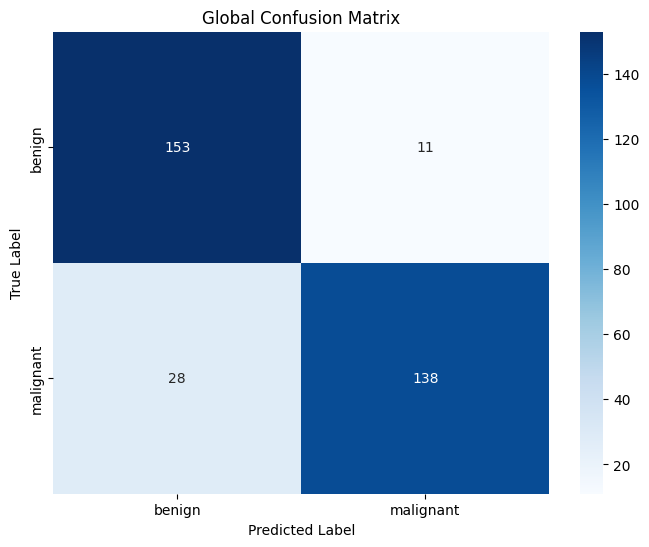

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Global Confusion Matrix')
plt.show()

## Model Saving to GDrive

In [27]:
import shutil
import os

source_dir = "/content/global_models/"
destination_dir = "/content/drive/MyDrive/Student/Mohit/Model/Federated_Learning_Project_2/FL_Global_Models/MobileNet_V2"

os.makedirs(destination_dir, exist_ok=True)

for item in os.listdir(source_dir):
    s = os.path.join(source_dir, item)
    d = os.path.join(destination_dir, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, dirs_exist_ok=True)
    else:
        shutil.copy2(s, d)

print(f"Copied contents of {source_dir} to {destination_dir}")

Copied contents of /content/global_models/ to /content/drive/MyDrive/Student/Mohit/Model/Federated_Learning_Project_2/FL_Global_Models/MobileNet_V2


### Reverse Load again if need in future

In [28]:
import shutil
import os

destination_dir = "/content/global_models/"
source_dir = "/content/drive/MyDrive/Student/Mohit/Model/Federated_Learning_Project_2/FL_Global_Models/MobileNet_V2"

os.makedirs(destination_dir, exist_ok=True)

for item in os.listdir(source_dir):
    s = os.path.join(source_dir, item)
    d = os.path.join(destination_dir, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, dirs_exist_ok=True)
    else:
        shutil.copy2(s, d)

print(f"Copied contents of {source_dir} to {destination_dir}")

Copied contents of /content/drive/MyDrive/Student/Mohit/Model/Federated_Learning_Project_2/FL_Global_Models/MobileNet_V2 to /content/global_models/
